$E_{x\sim p(x|\theta_0)}[q(\theta_0,\theta_1)] ~=~ \int p(x|\theta_0) \cdot q(x|\theta_0, \theta_1) dx$

$~\approx~ \frac{1}{N} \sum_{x\sim p(x|\theta_0)} q(x|\theta_0, \theta_1)$

In [13]:
import sys

import numpy       as np
from   scipy       import stats
from   iminuit     import Minuit
from   matplotlib  import pyplot as plt

In [2]:
f1_true     = 0.7
mu1_true    = -12
sigma1_true = 7.

f2_true     = 0.3
mu2_true    = 3
sigma2_true = 4.

N_per_mu    = 50

In [88]:
def pdf1 (x) :
    return stats.norm.pdf(x, mu1_true, sigma1_true)

def pdf2 (x, mu2_hyp) :
    return stats.norm.pdf(x, mu2_hyp, sigma2_true)

def pdf (x, mu2_hyp) :
    return f1_true*pdf1(x) + f2_true*pdf2(x, mu2_hyp)

def dpdf_dx (x, mu2_hyp) :
    pdf_1 = f1_true*stats.norm.pdf(x, mu1_true, sigma1_true)
    pdf_2 = f2_true*stats.norm.pdf(x, mu2_hyp , sigma2_true)
    return (mu1_true-x)*pdf_1/(sigma1_true*sigma1_true) + (mu2_hyp-x)*pdf_2/(sigma2_true*sigma2_true)

def q (x, mu2_hyp, mu2_ref) :
    return -2.*np.log(pdf(x, mu2_hyp)/pdf(x, mu2_ref))

def q_exp (x, mu2_hyp, mu2_ref) :
    return pdf(x, mu2_ref) * q(x, mu2_hyp, mu2_ref)

def q_exp_alt (x, mu2_hyp, mu2_ref) :
    return pdf(x, mu2_hyp) * q(x, mu2_hyp, mu2_ref)

def dq_dx (x, mu2_hyp, mu2_ref) :
    return -2. * ( (dpdf_dx(x,mu2_hyp)/pdf(x,mu2_hyp)) - (dpdf_dx(x,mu2_ref)/pdf(x,mu2_ref)) )

def importance (x, mu2_hyp, mu2_ref) :
    return pdf (x, mu2_ref) * dq_dx (x, mu2_hyp, mu2_ref)

def sample_pdf1 (num, mu=None) :
    if type(mu) == type(None) :
        mu = mu1_true
    return mu + sigma1_true*np.random.normal(size=(num,))

def sample_pdf2 (num, mu=None) :
    if type(mu) == type(None) :
        mu = mu2_true
    return mu + sigma2_true*np.random.normal(size=(num,))

def sample (num) :
    num1 = int(num*f1_true)
    num2 = num - num1
    ds1, ds2 = sample_pdf1(num1), sample_pdf2(num2)
    ds = np.concatenate([ds1, ds2])
    np.random.shuffle(ds)
    return ds

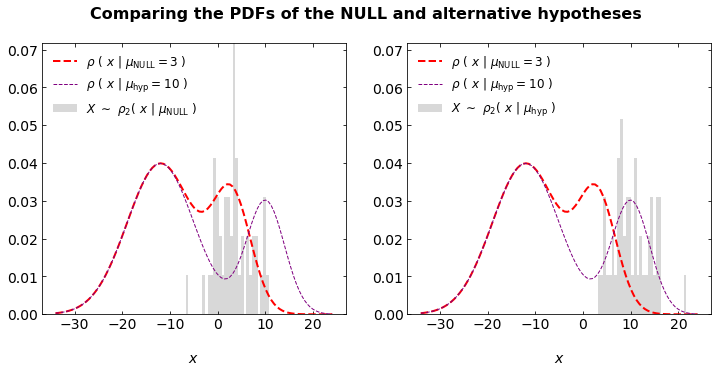

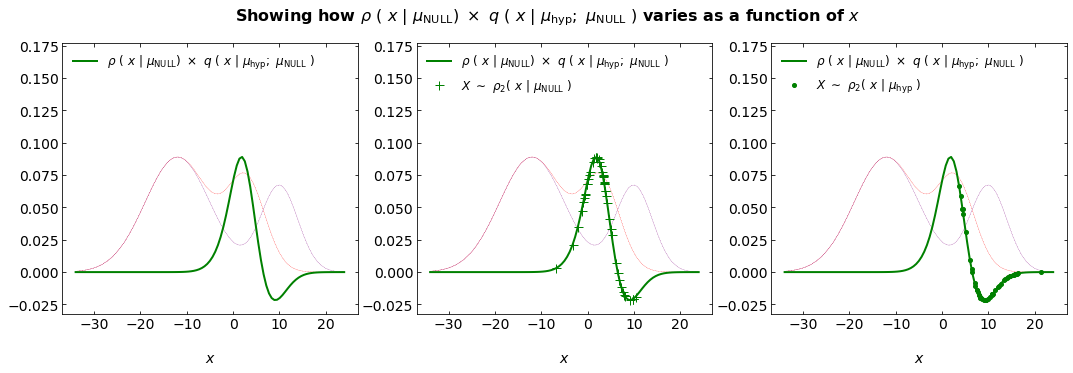

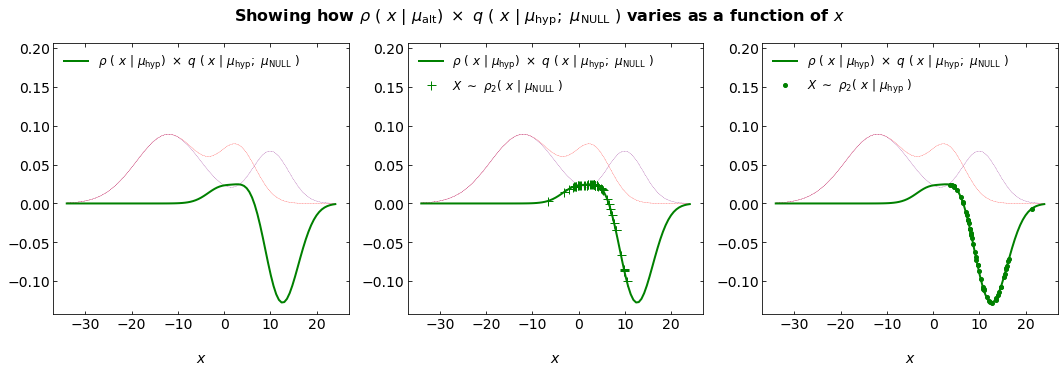

In [4]:
mu2_hyp = 10

bins              = np.linspace(-34, 24, 101)
pdf_profile       = pdf       (bins, mu2_true)
pdf_profile_hyp   = pdf       (bins, mu2_hyp )
imp_profile       = importance(bins, mu2_hyp, mu2_true)
q_profile         = q         (bins, mu2_hyp, mu2_true)
dq_profile        = dq_dx     (bins, mu2_hyp, mu2_true)
q_exp_profile     = q_exp     (bins, mu2_hyp, mu2_true)
q_exp_alt_profile = q_exp_alt (bins, mu2_hyp, mu2_true)

pdf_max                      = np.max(np.concatenate([pdf_profile, pdf_profile_hyp]))
q_exp_min, q_exp_max         = np.min(q_exp_profile), np.max(q_exp_profile)
q_exp_range                  = q_exp_max - q_exp_min
q_exp_alt_min, q_exp_alt_max = np.min(q_exp_alt_profile), np.max(q_exp_alt_profile)
q_exp_alt_range              = q_exp_alt_max - q_exp_alt_min
dataset_hyp                  = sample_pdf2(N_per_mu, mu2_hyp)
dataset_true                 = sample_pdf2(N_per_mu)

fig = plt.figure(figsize=(12, 5))
ax  = fig.add_subplot(1, 2, 1)
ax.hist(dataset_true, bins=bins, weights=np.full(shape=(N_per_mu,), fill_value=f2_true/N_per_mu/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.0f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.0f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 2, 2)
ax.hist(dataset_hyp , bins=bins, weights=np.full(shape=(N_per_mu,), fill_value=f2_true/N_per_mu/(bins[1]-bins[0])), density=False, color="grey", alpha=0.3, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL} = "+f"{mu2_true:.0f}$ )")
ax.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1, label=r"$\rho~(~x~|~\mu_{\rm hyp} = "+f"{mu2_hyp:.0f}$ )")
ax.set_ylim([0, 1.8*pdf_max])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle("Comparing the PDFs of the NULL and alternative hypotheses", weight="bold", fontsize=16)
plt.show()

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_true, q_exp(dataset_true, mu2_hyp, mu2_true), "+", c="g", markersize=9, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_hyp , q_exp(dataset_hyp , mu2_hyp, mu2_true), "o", c="g", markersize=4, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.set_ylim([q_exp_min-0.1*q_exp_range, q_exp_max+0.8*q_exp_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle(r"Showing how $\rho~(~x~|~\mu_{\rm NULL})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$ varies as a function of $x$", weight="bold", fontsize=16)
plt.show()

fig = plt.figure(figsize=(18, 5))
ax  = fig.add_subplot(1, 3, 1)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 2)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_true, q_exp_alt(dataset_true, mu2_hyp, mu2_true), "+", c="g", markersize=9, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm NULL}~)$")
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
ax  = fig.add_subplot(1, 3, 3)
ax.plot(bins, pdf_profile     * q_exp_max / pdf_max, "--", c="r"     , linewidth=0.3)
ax.plot(bins, pdf_profile_hyp * q_exp_max / pdf_max, "--", c="purple", linewidth=0.3)
ax.plot(bins, q_exp_alt_profile, "-", c="g", linewidth=2, label=r"$\rho~(~x~|~\mu_{\rm hyp})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$")
ax.plot(dataset_hyp , q_exp_alt(dataset_hyp , mu2_hyp, mu2_true), "o", c="g", markersize=4, label=r"$X~\sim~\rho_2 (~x~|~\mu_{\rm hyp}~)$" )
ax.set_ylim([q_exp_alt_min-0.1*q_exp_alt_range, q_exp_alt_max+1.2*q_exp_alt_range])
ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=14)
ax.legend(loc="upper left", frameon=False, fontsize=12)
ax.set_xlabel(r"$x$", fontsize=14, labelpad=20)
fig.suptitle(r"Showing how $\rho~(~x~|~\mu_{\rm alt})~\times~ q~(~x~|~\mu_{\rm hyp};~\mu_{\rm NULL}~)$ varies as a function of $x$", weight="bold", fontsize=16)
plt.show()


In [5]:
'''plt.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2)
plt.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1)
plt.plot(bins, q_profile     * np.max(pdf_profile) / np.max(np.fabs(q_profile    )), "--", c="gold", linewidth=1)
plt.plot(bins, dq_profile    * np.max(pdf_profile) / np.max(np.fabs(dq_profile   )), "--", c="gold", linewidth=1)
plt.plot(bins, imp_profile   * np.max(pdf_profile) / np.max(np.fabs(imp_profile  )), "-.", c="r", linewidth=1)
plt.show()'''

'plt.plot(bins, pdf_profile    , "--", c="r"     , linewidth=2)\nplt.plot(bins, pdf_profile_hyp, "--", c="purple", linewidth=1)\nplt.plot(bins, q_profile     * np.max(pdf_profile) / np.max(np.fabs(q_profile    )), "--", c="gold", linewidth=1)\nplt.plot(bins, dq_profile    * np.max(pdf_profile) / np.max(np.fabs(dq_profile   )), "--", c="gold", linewidth=1)\nplt.plot(bins, imp_profile   * np.max(pdf_profile) / np.max(np.fabs(imp_profile  )), "-.", c="r", linewidth=1)\nplt.show()'

In [52]:
L      = 100
xsec   = 10
n_exp  = L * xsec
n_as   = int(n_exp * 10000)

print(f"n_exp is {n_exp}")
print(f"n_as is {n_as}")

as_datapoints = sample(n_as)
as_weights    = n_exp / n_as

print("Fitting Asimov")
TNLL = lambda p : -2 * np.sum(as_weights*np.log(pdf(as_datapoints, p[0])))
m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
m.migrad()

print("Running Minos")
m.minos()
val  = m.values[0]
errs = m.get_merrors()["x0"]

print(f"Fit result is {val:.3f} + {errs.upper:.3f} - {np.fabs(errs.lower):.3f}")
mu2_scan_points = np.linspace(val+errs.lower, val+errs.upper, 51)
asimov_curve    = []


print("Scanning Asimov")
for mu2_hyp in mu2_scan_points :
    sys.stdout.write(f"\rmu2_hyp is {mu2_hyp:.3f} *****")
    TNLL    = -2 * np.sum(as_weights*np.log(pdf(as_datapoints, mu2_hyp)))
    asimov_curve.append(TNLL)

n_exp is 1000
n_as is 10000000
Fitting
Running Minos
Fit result is 2.998 + 0.287 -  + 0.285
mu2_hyp is 3.284 *****

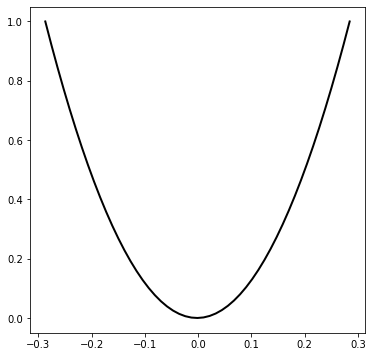

In [53]:
fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(mu2_scan_points - mu2_true, asimov_curve - np.min(asimov_curve), "-", linewidth=2, c="k")
plt.show()

In [96]:
n_toys = [300, 500, 1000, 3000, 5000, 10000, 30000, 50000, 100000]
num_toys = 1000

mu2_fit_results = {}
for n_toy in n_toys :
    sys.stdout.write(f"\rnum toys is {n_toy}")
    mu2_fit_results [n_toy] = []
    for toy_idx in range(num_toys) :
        sys.stdout.write(f"\rtoy size is {n_toy}, number is {toy_idx+1} / {num_toys} ********")
        toy_datapoints = sample(n_toy)
        toy_weights    = n_exp / n_toy
        TNLL = lambda p : -2 * np.sum(toy_weights*np.log(pdf(toy_datapoints, p[0])))
        m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
        m.migrad()
        if not m.get_fmin().is_valid :
            n_toy = n_toy - 1
            continue
        mu2_fit_results [n_toy].append(m.values[0])
        

toy size is 100000, number is 1000 / 1000 ********

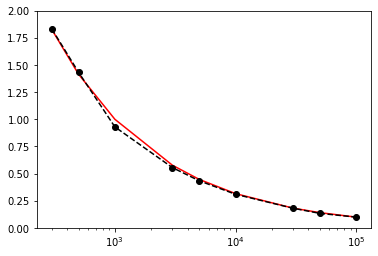

In [97]:
ref_std = np.mean([np.fabs(errs.lower), errs.upper])

y_mean, y_std, y_mean_err = [], [], []
for n_toy in n_toys :
    fit_results = mu2_fit_results [n_toy]
    mean = np.mean(fit_results)
    std  = np.std (fit_results)
    y_mean    .append(mean)
    y_std     .append(std)
    y_mean_err.append(std / np.sqrt(len(fit_results)))
y_mean, y_std, y_mean_err = np.array(y_mean), np.array(y_std), np.array(y_mean_err)

plt.plot(n_toys, np.sqrt(n_exp/np.array(n_toys)), "-", c="r")
plt.plot(n_toys, y_std/ref_std, "o-", c="k", linestyle="--")
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim([0.05, 3])
plt.show()

In [98]:
mu2_fit_results_imp_samp = {}
for n_toy in n_toys :
    sys.stdout.write(f"\rnum toys is {n_toy}")
    mu2_fit_results_imp_samp [n_toy] = []
    for toy_idx in range(num_toys) :
        sys.stdout.write(f"\rtoy size is {n_toy}, number is {toy_idx+1} / {num_toys} ********")
        toy_datapoints = sample_pdf2(n_toy)
        toy_weights    = (n_exp / n_toy) * pdf(toy_datapoints, mu2_true) / pdf2(toy_datapoints, mu2_true)
        TNLL = lambda p : -2 * np.sum(toy_weights*np.log(pdf(toy_datapoints, p[0])))
        m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
        m.migrad()
        if not m.get_fmin().is_valid :
            n_toy = n_toy - 1
            continue
        mu2_fit_results_imp_samp [n_toy].append(m.values[0])
        

toy size is 100000, number is 1000 / 1000 ********

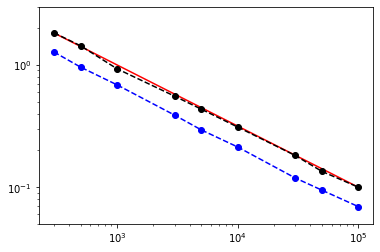

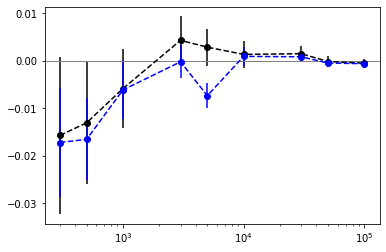

In [102]:

y2_mean, y2_std, y2_mean_err = [], [], []
for n_toy in n_toys :
    fit_results = mu2_fit_results_imp_samp [n_toy]
    mean = np.mean(fit_results)
    std  = np.std (fit_results)
    y2_mean    .append(mean)
    y2_std     .append(std)
    y2_mean_err.append(std / np.sqrt(len(fit_results)))
y2_mean, y2_std, y2_mean_err = np.array(y2_mean), np.array(y2_std), np.array(y2_mean_err)

plt.plot(n_toys, np.sqrt(n_exp/np.array(n_toys)), "-", c="r")
plt.errorbar(n_toys, y_std /ref_std, yerr=(y_std /ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="k")
plt.errorbar(n_toys, y2_std/ref_std, yerr=(y2_std/ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="b")
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim([0.05, 3])
plt.show()

plt.errorbar(n_toys, y_mean  - mu2_true, yerr=y_mean_err , fmt="o--", c="k")
plt.errorbar(n_toys, y2_mean - mu2_true, yerr=y2_mean_err, fmt="o--", c="b")
plt.gca().set_xscale("log")
plt.gca().axhline(0, linestyle="-", c="grey", linewidth=1)
plt.show()

n_test is 1000


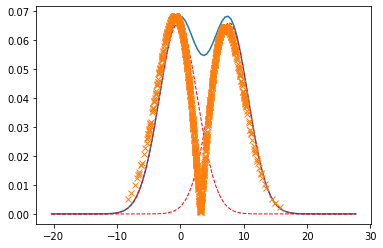

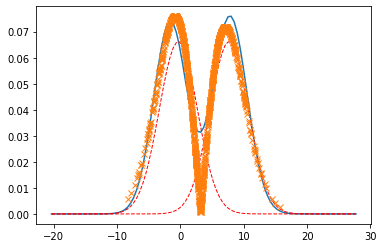

In [182]:
n_test = int(n_exp)

print(f"n_test is {n_test}")

toy_datapoints = sample_pdf2 (n_test)
toy_weights    = (n_exp / n_test) * pdf(toy_datapoints, mu2_true) / pdf2(toy_datapoints, mu2_true)
importance     = q (toy_datapoints, mu2_true + errs.upper, mu2_true)
exp_importance = importance * pdf(toy_datapoints, mu2_true)

n_g       = 2
sigma_min = 1e-2

def model_prob (x, params, i=-1) :
    means       = params[     :n_g  ]
    sigmas      = 1e-2 + np.exp(params[n_g  :2*n_g])
    frequencies = params[2*n_g:     ]
    frequencies = np.concatenate([frequencies, [1-np.sum(frequencies)]])
    prob = 0.
    if i < 0 :
        for i in range(n_g) :
            prob = prob + frequencies[i] * stats.norm.pdf(x, means[i], sigmas[i])
    else :
        prob = prob + frequencies[i] * stats.norm.pdf(x, means[i], sigmas[i])
    return prob
    
def loss (params) :
    logL_dp = np.log(model_prob (toy_datapoints, params))
    logL    = np.sum(np.fabs(importance) * toy_weights * logL_dp)
    return - logL

dp_min, dp_max = np.min(toy_datapoints), np.max(toy_datapoints)
dp_range       = dp_max - dp_min
start_means  = np.linspace(dp_min, dp_max, n_g+2)[1:-1]
start_sigmas = np.full(shape=(n_g  ), fill_value=np.log(dp_range/n_g/4))
start_freq   = np.full(shape=(n_g-1), fill_value=1       /n_g)
start_params = np.concatenate([start_means, start_sigmas, start_freq])

scan_x  = np.linspace(dp_min-0.5*dp_range, dp_max+0.5*dp_range, 101)
scan_y  = model_prob(scan_x, start_params)
indiv_y = [model_prob(scan_x, start_params, i) for i in range(n_g)]

plt.plot(scan_x, scan_y)
for scan_y_i in indiv_y :
    plt.plot(scan_x, scan_y_i, "--", linewidth=1, c="r")
plt.plot(toy_datapoints, np.fabs(exp_importance)*np.max(scan_y)/np.max(np.fabs(exp_importance)), "x")
plt.show()

m = Minuit.from_array_func(loss, start_params, start_params, errordef=1)
m.migrad()
end_params = m.np_values()

scan_y = model_prob(scan_x, end_params)
plt.plot(scan_x, scan_y)
for scan_y_i in indiv_y :
    plt.plot(scan_x, scan_y_i, "--", linewidth=1, c="r")
plt.plot(toy_datapoints, np.fabs(exp_importance)*np.max(scan_y)/np.max(np.fabs(exp_importance)), "x")
plt.show()

In [187]:

def sample_model_prob (num_pts, params, i=-1) :
    means         = params[     :n_g  ]
    sigmas        = sigma_min + np.exp(params[n_g  :2*n_g])
    frequencies   = params[2*n_g:     ]
    frequencies   = np.concatenate([frequencies, [1-np.sum(frequencies)]])
    if i < 0 :
        gauss_choices = np.random.choice(n_g, p=frequencies, size=(num_pts,))
    else :
        gauss_choices = np.full(shape=(num_pts,), fill_value=i)
    datapoints    = []
    for i in range(n_g) :
        num_i = len([True for c in gauss_choices if c==i])
        datapoints.append(means[i] + sigmas[i]*np.random.normal(size=(num_i,)))
    ret = np.concatenate(datapoints)
    np.random.shuffle(ret)
    return ret

In [188]:
mu2_fit_results_optimal = {}
for n_toy in n_toys :
    sys.stdout.write(f"\rnum toys is {n_toy}")
    mu2_fit_results_optimal [n_toy] = []
    for toy_idx in range(num_toys) :
        sys.stdout.write(f"\rtoy size is {n_toy}, number is {toy_idx+1} / {num_toys} ********")
        toy_datapoints = sample_model_prob(n_toy, end_params)
        toy_weights    = (n_exp / n_toy) * pdf(toy_datapoints, mu2_true) / model_prob(toy_datapoints, end_params)
        TNLL = lambda p : -2 * np.sum(toy_weights*np.log(pdf(toy_datapoints, p[0])))
        m = Minuit.from_array_func(TNLL, [mu2_true], [1], errordef=1)
        m.migrad()
        if not m.get_fmin().is_valid :
            n_toy = n_toy - 1
            continue
        mu2_fit_results_optimal [n_toy].append(m.values[0])

toy size is 100000, number is 1000 / 1000 ********

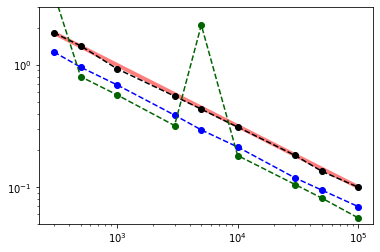

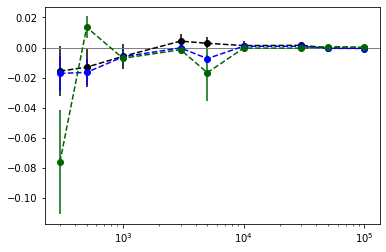

In [190]:

y3_mean, y3_std, y3_mean_err = [], [], []
for n_toy in n_toys :
    fit_results = mu2_fit_results_optimal [n_toy]
    mean = np.mean(fit_results)
    std  = np.std (fit_results)
    y3_mean    .append(mean)
    y3_std     .append(std)
    y3_mean_err.append(std / np.sqrt(len(fit_results)))
y3_mean, y3_std, y3_mean_err = np.array(y3_mean), np.array(y3_std), np.array(y3_mean_err)

plt.plot(n_toys, np.sqrt(n_exp/np.array(n_toys)), "-", c="r", alpha=0.5, linewidth=4)
plt.errorbar(n_toys, y_std /ref_std, yerr=(y_std /ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="k")
plt.errorbar(n_toys, y2_std/ref_std, yerr=(y2_std/ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="b")
plt.errorbar(n_toys, y3_std/ref_std, yerr=(y3_std/ref_std)/np.sqrt(2*num_toys-2), fmt="o--", c="darkgreen")
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim([0.05, 3])
plt.show()

plt.errorbar(n_toys, y_mean  - mu2_true, yerr=y_mean_err , fmt="o--", c="k")
plt.errorbar(n_toys, y2_mean - mu2_true, yerr=y2_mean_err, fmt="o--", c="b")
plt.errorbar(n_toys, y3_mean - mu2_true, yerr=y3_mean_err, fmt="o--", c="darkgreen")
plt.gca().set_xscale("log")
plt.gca().axhline(0, linestyle="-", c="grey", linewidth=1)
plt.show()